In [ ]:
# default_exp bayesian_deep_learning

# bayesian_deep_learning

> API details.

## Bayesian Neural Networks in PyMC3

In [ ]:
%matplotlib inline
import theano
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Generating data

In [ ]:
X, Y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X = scale(X)
X = X.astype(float)
Y = Y.astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [ ]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((500, 2), (500,), (500, 2), (500,))

In [ ]:
X[Y==0, 0].shape

(500,)

[Text(0, 0.5, 'Y'),
 Text(0.5, 0, 'X'),
 Text(0.5, 1.0, 'Toy binary classification dataset')]

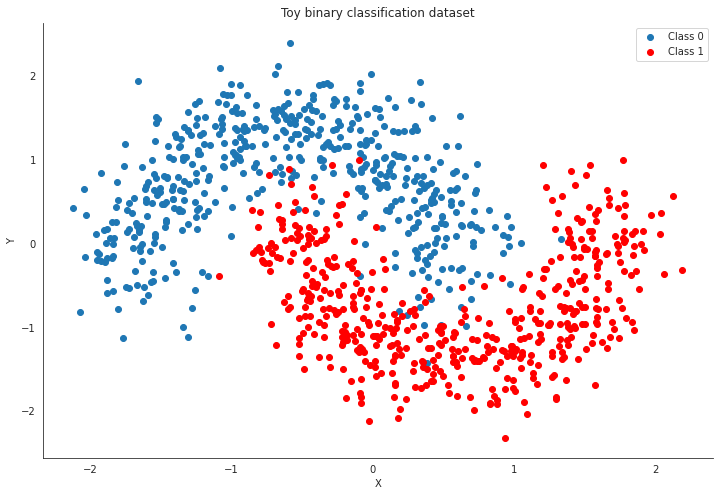

In [ ]:
# Plot data
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], label='Class 1', color='r')
sns.despine()
ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification dataset')

### Model specification
Here we will use 2 hidden layers with 5 neurons

In [ ]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)
    
    with pm.Model() as neural_network:
        # Weights from input to hidden layers
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,),
                                  testval=init_out)
        
        # Build neural-network using tanh activation
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', act_out, observed=ann_output,
                           total_size=Y_train.shape[0]) # Important for minibatches
    return neural_network
        

In [ ]:
%%time
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

CPU times: user 422 ms, sys: 227 ms, total: 649 ms
Wall time: 17 s


### Variational Inference: Scaling model complexity

In [ ]:
# !pip uninstall theano-pymc  # run a few times until it says not installed
# !pip install "pymc3<3.10" "theano==1.0.5"
# Better using:
# !conda install "CPython==3.7.7" "pymc3==3.9.0" "theano==1.0.4" 

In [ ]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

set_tt_rng(MRG_RandomStreams(42))

In [ ]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)

Finished [100%]: Average Loss = 122.57


CPU times: user 15 s, sys: 435 ms, total: 15.5 s
Wall time: 38.6 s


In [ ]:
trace = approx.sample(draws=5000)

Text(0.5, 0, 'iteration')

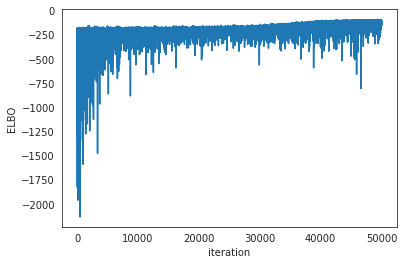

In [ ]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration')

### Prediction

In [ ]:
# Replace arrays our NN references with test data
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

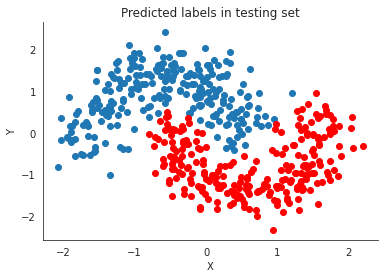

In [ ]:
# Plot predictions
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [ ]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 95.0%


### what the classifier has learned

In [ ]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [ ]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False)

#### Probability surface

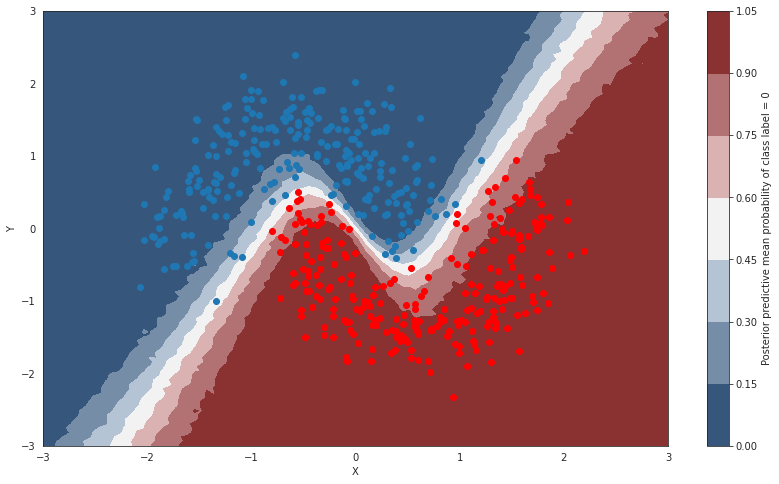

In [ ]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

#### Uncertainty in predicted value

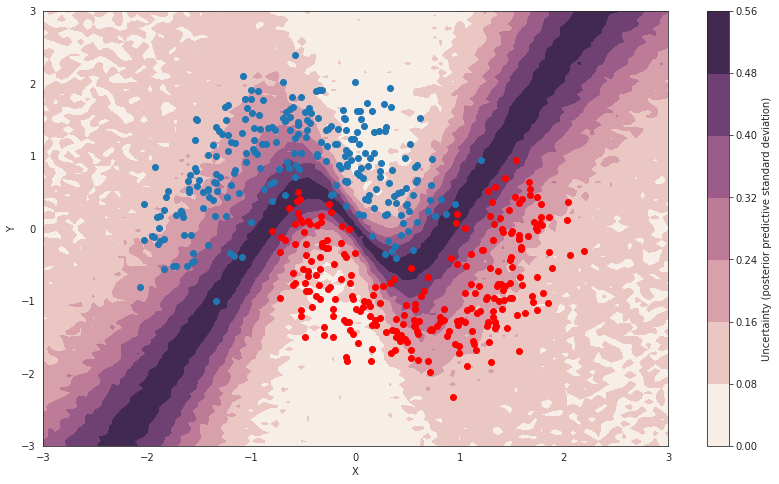

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

#### Source
https://twiecki.io/blog/2016/06/01/bayesian-deep-learning/#Uncertainty-in-predicted-value